<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es3/AML_2023_HandsOn_3_SimCLR_CNN_v2_0_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np


In [2]:
import os, sys, tarfile

def extract(tar_url, extract_path='.'):
    print(tar_url)
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
def CreateDir(path):
	# Create a directory if it does not exist
	success = os.path.exists(path)
	if not success:
		os.makedirs(path)
  
CreateDir("/content/gdrive/MyDrive/AuroreBoreali")#your folder,


In [5]:
cd /content/gdrive/MyDrive/AuroreBoreali

/content/gdrive/MyDrive/AuroreBoreali


In [6]:
if not os.path.exists("/content/gdrive/MyDrive/AuroreBoreali/oath_v1.1"):
  extract("/content/gdrive/MyDrive/AuroreBoreali/oath_v1.1_20181026.tgz", extract_path='.')

In [7]:
import pandas as pd
df = pd.read_csv("oath_v1.1/classifications/classifications.csv", skiprows=18)

In [8]:
print(df.head(10))
labels = df['class6'].to_numpy()
print(np.unique(labels))

   class2  class6  picNum   picType  rotAng
0       0       2       1  discrete     334
1       0       2       2  discrete      29
2       0       2       3  discrete     355
3       0       0       4       arc     118
4       0       0       5       arc      55
5       0       1       6   diffuse      12
6       0       1       7   diffuse     334
7       0       1       8   diffuse      29
8       0       1       9   diffuse     355
9       0       1      10   diffuse      24
[0 1 2 3 4 5]


In [9]:
print("labels shape (N images classified)",labels.shape)

labels shape (N images classified) (5824,)


In [10]:
import matplotlib.pyplot as plt
image_folder = "oath_v1.1/images/cropped_scaled/"
# array = plt.imread('my_picture.png')

def paper_norm(image):# normalization as described in the paper
  im = image
  m = np.percentile(im,1)
  t = im-np.percentile(im,1)
  M = np.percentile(t,99)
  im = t/M
  return np.maximum(np.minimum(im,1),0)


In [11]:
images_path = os.listdir(image_folder)
images_path.sort()# this is important. Why?
print(images_path[0:10])

['00001.png', '00002.png', '00003.png', '00004.png', '00005.png', '00006.png', '00007.png', '00008.png', '00009.png', '00010.png']


In [12]:


if not os.path.exists("/content/gdrive/MyDrive/AuroreBoreali/oath_v1.1/images.npz"):
  images = np.zeros((labels.shape[0],176,176))#preallocating
  for i, path in enumerate(images_path):
      # check if current path is a file
      if path.endswith('.png'):# check image estention
        #print(path)
        tmp_image = plt.imread(image_folder+path)[40:216,40:216,1]# original size is 256x256, cropped as described in the paper
        tmp_image = paper_norm(tmp_image)
        images[i,:,:]=tmp_image
  np.savez_compressed("/content/gdrive/MyDrive/AuroreBoreali/oath_v1.1/images.npz",images=images)
  print("preprocessed data saved!")
else:
 images =  np.load("/content/gdrive/MyDrive/AuroreBoreali/oath_v1.1/images.npz")["images"]
 print("preprocessed data loaded!")

preprocessed data loaded!


In [13]:
print("number of images",len(images))
print("imm shape: ",images[0].shape)
def plot_example(image,lab):
  f,[ax,ax2] = plt.subplots(1,2,figsize=(8,5))
  ax.matshow(image)
  classes = ["arc", "diffuse", "discrete", "cloudy","moon","clear"]
  ax.set_title("An example of class {}".format(classes[lab]),fontsize=15)
  ax2.hist(image.reshape(-1),20)
  

number of images 5824
imm shape:  (176, 176)


In [14]:
[np.where(labels==0)[0][0],# the first of this class
np.where(labels==1)[0][0],
np.where(labels==2)[0][0],
np.where(labels==3)[0][0],
np.where(labels==4)[0][0],
np.where(labels==5)[0][0],]

[3, 5, 0, 750, 567, 206]

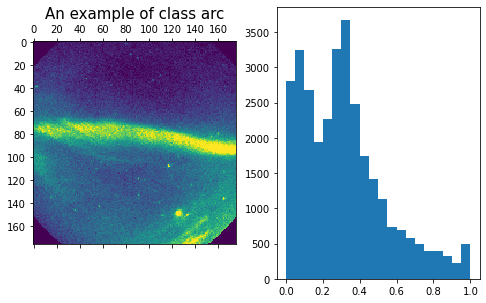

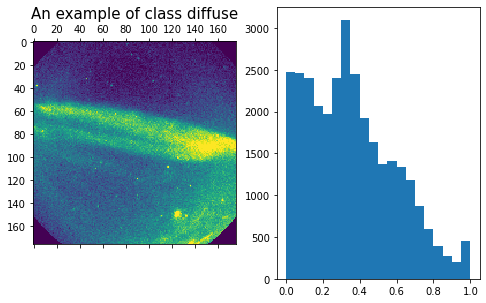

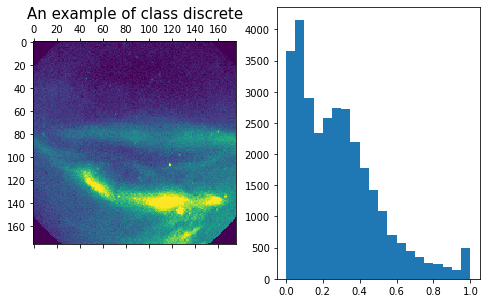

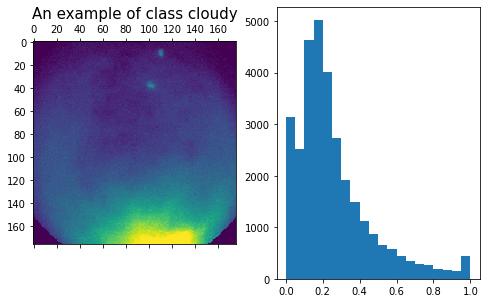

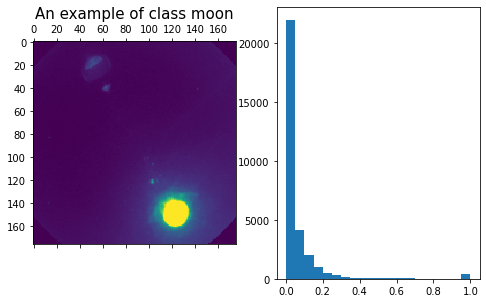

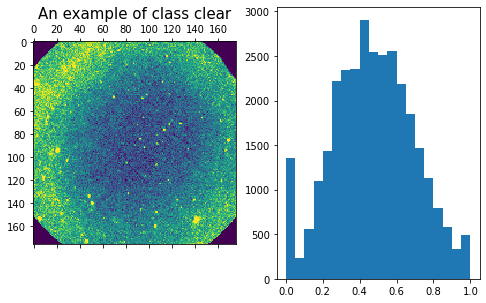

In [15]:
plot_example(images[3],labels[3])# always visualize the data!
plot_example(images[5],labels[5])
plot_example(images[0],labels[0])
plot_example(images[750],labels[750])
plot_example(images[567],labels[567])
plot_example(images[206],labels[206])

In [16]:
from sklearn.model_selection import train_test_split

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [17]:
#define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla T4
Computation device: cuda



In [18]:
testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(images,labels,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

X_train = np.expand_dims(X_train, 1)
X_vali = np.expand_dims(X_vali, 1)
X_test = np.expand_dims(X_test, 1)

print("X train shape: ",X_train.shape)
print("X test shape: ",X_test.shape)
print("X vali shape: ",X_vali.shape)

X train shape:  (3494, 1, 176, 176)
X test shape:  (1165, 1, 176, 176)
X vali shape:  (1165, 1, 176, 176)


In [19]:
images=[]# save a bit of memory

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([3494, 1, 176, 176])
torch.Size([3494])
torch.Size([1165, 1, 176, 176])
torch.Size([1165])
torch.Size([1165, 1, 176, 176])
torch.Size([1165])


In [20]:
import torch
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self, num_classes=6):
        super(VGG, self).__init__()
        
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional block
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth convolutional block
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 11 * 11, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
        )

        self.out = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.out(x)
        return x

    def latent(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [21]:
model = VGG()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,X_train.shape[2],X_train.shape[3]))
else:
  summary(model, input_size=(1,X_train.shape[2],X_train.shape[3]))

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

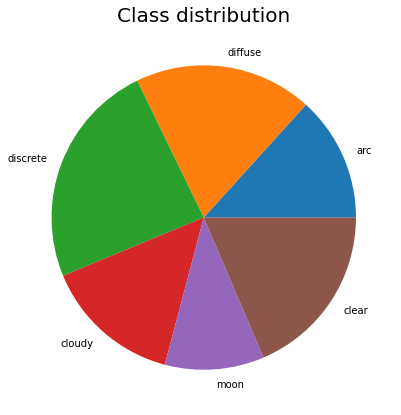

[7.5245478  5.28493648 4.16       6.83568075 9.48534202 5.38262477]


In [22]:
def piechartclasses(y_all):
  classes = y_all
  c = np.unique(classes)
  arr_c = [np.mean(classes==i) for i in c]


 
  # Creating plot
  fig = plt.figure(figsize =(10, 7))
  plt.pie(arr_c, labels = ["arc", "diffuse", "discrete", "cloudy","moon","clear"])
 
  # show plot
  plt.title("Class distribution",fontsize=20)
  plt.show()
  return arr_c
arr_c = piechartclasses(labels) 
print(1/np.array(arr_c))

In [23]:
#loss  weight = torch.Tensor(np.array(arr_c).sum()/np.array(arr_c)).to(device)
loss_func = nn.CrossEntropyLoss(weight = torch.Tensor(np.array(arr_c).sum()/np.array(arr_c)).to(device)) # cross entropy loss, weigthed for class unbalance

#metric accuracy
def accuracy(y_pred, y_true):
  """
  Calculates the accuracy of the predicted labels.

  Args:
      y_pred (torch.Tensor): predicted labels
      y_true (torch.Tensor): true labels

  Returns:
      float: accuracy score
  """
  # Get the predicted class by finding the index of the maximum value along axis 1
  y_pred = torch.argmax(y_pred, axis=1)
  #y_true = torch.argmax(y_true, axis=1)

  # Calculate the number of correctly classified examples
  correct = (y_pred == y_true).sum().item()

  # Calculate the total number of examples
  total = len(y_true)

  # Calculate the accuracy
  acc = correct / total

  return acc

metric_func = accuracy

# optim
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-3)
# scheduler for step decay lr schedule
scheduler = optim.lr_scheduler.StepLR(opt, 10, gamma=0.1, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 3.0000e-03.


In [24]:
# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)

The model is in the:  cpu
now the model is in the:  cuda:0


In [25]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf'),filename='best_model_supervised.pth'): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.filename=filename
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, self.filename)

In [26]:
epochs = 30
batch_size = 64

# define dataloaders
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) 
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,num_workers=2,prefetch_factor=4) 

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
dataloader_vali = DataLoader(dataset_vali, batch_size=batch_size) 

In [27]:
#training loop
TRAIN_SUPEVISED=0
TEST_SUPERVISED=0
import time
if TRAIN_SUPEVISED:# switch to zero to avoid training the supervised model
  save_best_model = SaveBestModel()

  # lists to save loss and metric history
  hist_loss = []
  hist_metric = []
  hist_vloss = []
  hist_vmetric = []

  #loop over epochs
  for epoch in range(epochs):
      t0 = time.time()

      #training step
      model.train()

      train_loss = 0.0
      train_metric = 0.0
      counter = 0
      for xb, yb in dataloader_train: #takes a batch from the train dataloader 
          counter += 1 
          xb=xb.to(device) #move troch tensors to device (cpu or GPU)
          yb=yb.type(torch.LongTensor).to(device)
          
          pred = model(xb) #get prediction for batch
          loss = loss_func(pred, yb) #compute loss
          metric = metric_func(pred, yb) #compute metric

          train_loss += loss.item() #update total loss
          train_metric += metric #update total metric

          # backpropagation
          loss.backward()
          # update weights
          opt.step()
          # set to zero gradients for the next step
          opt.zero_grad()
  
      # normalize loss and metric by number of batches
      train_loss = train_loss/counter
      train_metric = train_metric/counter

      # update history
      hist_loss.append(train_loss)
      hist_metric.append(train_metric)


      # evaluation setp (same as trainign but w/o backpropagation)
      model.eval()

      vali_loss = 0.0
      vali_metric = 0.0
      counter = 0
      with torch.no_grad():
        for xb, yb in dataloader_vali:
          counter += 1
          xb=xb.to(device)
          yb=yb.type(torch.LongTensor).to(device)
          pred = model(xb)
          vloss = loss_func(pred, yb)
          vmetric = metric_func(pred, yb)
          vali_loss += vloss.item()
          vali_metric += vmetric
          
      vali_loss = vali_loss/counter
      vali_metric = vali_metric/counter    

      hist_vloss.append(vali_loss)
      hist_vmetric.append(vali_metric)

      #save best model
      save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

      elapsed_time = time.time()-t0
      print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

      # update learning rate schedule
      scheduler.step()

In [28]:
if TRAIN_SUPEVISED:
  xb = []
  yb = []
  plt.figure(figsize=(10, 7))
  plt.subplot(1,2,1)
  plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
  plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
  plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
  plt.xlabel('Epochs')
  plt.ylabel('Metric')
  plt.legend()

In [29]:
model = VGG()

best_model = torch.load('best_model_supervised.pth')
best_model_epoch = best_model['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

model.load_state_dict(best_model['model_state_dict'])
model.eval()

#let's do this on cpu (inference is fast)
model.to(torch.device('cpu'))

Best model was saved at 30 epochs



VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

dataset_test = TensorDataset(X_test_pt, Y_test_pt) 
dataloader_test = DataLoader(dataset_test, batch_size=batch_size) 

def test_model(model, dataloader_test):
    model.eval()

    y_true = []
    y_pred = []
    latent_space = []

    with torch.no_grad():
        for  i ,(inputs, targets) in enumerate(dataloader_test):# if it is too slow you can put it on the GPU!
            print(i)
            outputs = model(inputs)
            latent_repr = model.latent(inputs)
            targets = targets.numpy()
            outputs = outputs.numpy()
            latent_repr = latent_repr.numpy()

            predicted = np.argmax(outputs, 1)
            #targets = np.argmax(targets , 1)

            y_true.extend(targets)
            y_pred.extend(predicted)
            latent_space.extend(latent_repr)

    cm = confusion_matrix(y_true, y_pred,normalize="true")

    return np.array(y_true), np.array(y_pred), cm,latent_space

if  TEST_SUPERVISED:
  y_true,y_pred,cm,latent_space=test_model(model, dataloader_test)
  np.save("cm.npy",cm)
  np.savez("supervised_latent.npz",latent_space=latent_space,y_true=y_true,y_pred=y_pred)

  y_true,y_pred,cm,latent_space=test_model(model, dataloader_vali)
  
  np.savez("supervised_latent_vali.npz",latent_space=latent_space,y_true=y_true,y_pred=y_pred)
else:
  cm=np.load("cm.npy")

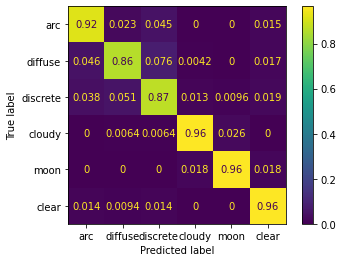

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["arc", "diffuse", "discrete", "cloudy","moon","clear"])
disp.plot()

plt.show()

# SimCLR

First part delas with the dataset creation and data augmentation. We'll do that by creating a torch Dataset custom class and a custom transformation function that will apply a torch transofrmation set to the input image and produce in output two augmented version of each image.


In [32]:
import torchvision
from torchvision import transforms, utils

# custom class that takes an image and outputs n_views random ransformation according to the 
# base_transforms list 
class ContrastiveTransformations(object):
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [33]:
# Data-augmentation transformations
# compose 4 different transformations from the trochvision lib: random horizontal pixels flip, random vertical pixels flip, random rotation, and random crop of the image

contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=10),
                                          #transforms.RandomVerticalFlip(),#the paper consider it harmful
                                          transforms.RandomRotation(15.),#the paper do not consider it 
                                          transforms.RandomResizedCrop(size=X_train.shape[2],scale=(0.50, 1.0)),
                                         ])

In [34]:
from operator import indexOf
# create a custom dataset
from torch.utils.data import Dataset, DataLoader

class AuroraData(Dataset):# this is a child of the dataset class
    """AuroraData dataset."""

    def __init__(self, data, labels, phase='train', transform=None):
        """
        Args:
            data: torch tensor containing images
            labels: torch tensor containing associated label
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.phase = phase
        self.data = data
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]
        label = self.label[idx]

        if self.transform:
          if self.phase == 'train':
            sample = self.transform(sample)
          else: 
            sample = [sample, sample]

        
        return sample, label

In [35]:
# create the dataset
VISUALIZE_DATA = 0
dataset_img = AuroraData(data=X_train_pt, labels=Y_train_pt, phase='train', transform=ContrastiveTransformations( base_transforms=contrast_transforms, n_views=2))
dataset_img_v = AuroraData(data=X_vali_pt, labels=Y_vali_pt, phase='vali', transform=ContrastiveTransformations( base_transforms=contrast_transforms, n_views=2))

In [36]:
if VISUALIZE_DATA:
  for i in range(len(dataset_img)):
    images, label = dataset_img[i]
    print(images[0].shape, images[1].shape)
    print(label.shape)
    plot_example(X_train_pt[i].detach().numpy().squeeze(),int(Y_train_pt[i].detach().numpy() ))# the original
    plot_example(images[0].detach().numpy().squeeze(),int(label.detach().numpy() ))# transformed 1
    plot_example(images[1].detach().numpy().squeeze(),int(label.detach().numpy() ))# transformed 2
    if i >2:
      break

In [37]:
# create the dataloaders (make sure to drop images that do not cope with the batch_size=64 requirement)
batch_size = 64
dataloader_img = DataLoader(dataset_img, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=2,prefetch_factor=4) 
dataloader_img_v = DataLoader(dataset_img_v, batch_size=batch_size, shuffle=True, drop_last=True)

In [38]:
# test it
if VISUALIZE_DATA:
  x1,x2 = next(iter(dataloader_img))# 64 pairs of transformed images
  print(x1[0].shape, x1[1].shape, x2.shape )

In [39]:
if VISUALIZE_DATA:
  plot_example(x1[0][0].detach().numpy().squeeze(),int(x2[0].detach().numpy() ))
  plot_example(x1[1][0].detach().numpy().squeeze(),int(x2[0].detach().numpy() ))

In [40]:
if VISUALIZE_DATA:
  plot_example(x1[0][2].detach().numpy().squeeze(),int(x2[2].detach().numpy() ))
  plot_example(x1[1][2].detach().numpy().squeeze(),int(x2[2].detach().numpy() ))

# Build the model

In [41]:



class VGGBaseModel(nn.Module):
    def __init__(self, num_classes=6):
        super(VGGBaseModel, self).__init__()
        
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional block
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth convolutional block
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 11 * 11, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
       
        return x

    

In [42]:
class ProjectionHead(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               out_features, **kwargs):
    super(ProjectionHead, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.hidden_features = hidden_features

    self.layers = nn.Sequential(
      nn.Linear(self.in_features, self.hidden_features, bias=True),
      nn.BatchNorm1d(self.hidden_features),
      nn.ReLU(),
      nn.Linear(self.hidden_features, self.out_features, bias=False),
      nn.BatchNorm1d(self.out_features)
    )

  def forward(self,x):
    out = self.layers(x)
    return out

In [43]:
class SimCLRModel(nn.Module):
  def __init__(self, base_model, proj_head):
    super(SimCLRModel, self).__init__()
    self.base_model = base_model
    self.proj_head = proj_head

  def forward(self,x):
    out = self.base_model(x)
    out = self.proj_head(out) 
    return out

In [44]:
basemodel = VGGBaseModel()
model = SimCLRModel(basemodel, ProjectionHead(128, 256, 128))
print(model)

print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,X_train.shape[2],X_train.shape[3]))
else:
  summary(model, input_size=(1,X_train.shape[2],X_train.shape[3]))

SimCLRModel(
  (base_model): VGGBaseModel(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=

In [45]:


model = model.to(device)



In [46]:
# NCELoss function
# from https://github.com/Spijkervet/SimCLR implementation

class NCELoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(NCELoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [47]:
# utulity function to plot during training the quality of the learned representation
# plots tSNE 2D distributions of learned representation
# for tSNE: see https://scikit-learn.org/stable/modules/manifold.html#t-sne

from sklearn.manifold import TSNE

def plot_features(model, num_classes, num_feats, batch_size, val_df = None):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    labs = np.array([])
    model.eval()
    with torch.no_grad():
        for img, lab in dataloader_img_v:
            x1 = img[0]
            x1 = x1.to(device = device, dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats,out,axis = 0)
            labs = np.append(labs,lab,axis = 0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    num_samples = len(dataloader_img_v)

    for i in range(num_classes):
        plt.scatter(x_feats[labs==i,1],x_feats[labs==i,0])
    
    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

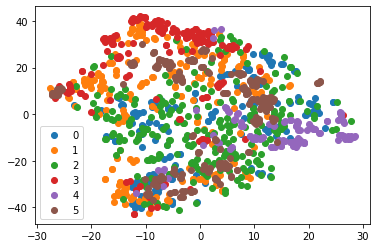

In [48]:
plot_features(model,6, 128, 64)# non trained model

In [49]:
# Train and Validation function

def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (img, lab) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = img[0]
        x_j = img[1]
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)
        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

def valid(valid_loader, model, criterion):
    loss_epoch = 0
    for step, (img, lab) in enumerate(valid_loader):
        x_i = img[0]
        x_j = img[1]
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        
        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [50]:
class SaveBestModelUN:
    def __init__(self, best_valid_loss=float('inf'),filename='best_model_UNsupervised.pth'): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        self.filename=filename
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                
                }, self.filename)

In [51]:
optimizer  = optim.Adam(model.parameters(), lr=5e-4)
# scheduler for step decay lr schedule
scheduler  = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.2, last_epoch=-1, verbose=True)

criterion = NCELoss(batch_size = 64, temperature = 0.5)

Adjusting learning rate of group 0 to 5.0000e-04.


In [ ]:
# Train loop
save_best_model = SaveBestModelUN(filename='best_model_supervised.pth')
tr_loss = []
val_loss = []

nr = 0
global_step = 0
current_epoch = 0
epochs = 45

for epoch in range(epochs):
        
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dataloader_img, model, criterion, optimizer)
    scheduler.step()
    
    
    lr = optimizer.param_groups[0]["lr"]

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(dataloader_img_v, model, criterion)

    if nr == 0:
        
        tr_loss.append(tr_loss_epoch / len(dataloader_img))
        
        val_loss.append(val_loss_epoch / len(dataloader_img_v))
        
        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dataloader_img)}\t lr: {round(lr, 5)}"
        )
        print(
            f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(dataloader_img_v)}\t lr: {round(lr, 5)}"
        )
        current_epoch += 1

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")
    save_best_model(vali_loss, epoch, model, opt, loss_func)

    if (epoch+1)%10==0:
        plot_features(model,6, 128, 64)

Epoch [0/45]	
Step [0/54]	 Loss: 4.63106


In [ ]:
basemodel=model.base_model
basemodel.eval()

#let's do this on cpu (inference is fast)
basemodel.to(torch.device('cpu'))

In [ ]:
#dataloader_vali

def extract_unsupervised_rep(model, dataloader_test):
    model.eval()

    latent_space = []
    y_true = []

    with torch.no_grad():
        for  i ,(inputs, targets) in enumerate(dataloader_test):# if it is too slow you can put it on the GPU!
            print(i)
            outputs = model(inputs)
            outputs = outputs.numpy()
            targets = targets.numpy()

            latent_space.extend(outputs)
            y_true.extend(targets)

    return latent_space,y_true


TEST_UNSUPERVISED = 1
if  TEST_UNSUPERVISED:
  latent_space,y_true=extract_unsupervised_rep(basemodel, dataloader_test)
 
  np.savez("unsupervised_latent.npz",latent_space = latent_space, y_true = y_true)

  latent_space,y_true=extract_unsupervised_rep(basemodel, dataloader_vali)

  np.savez("unsupervised_latent_vali.npz",latent_space = latent_space, y_true = y_true)

In [ ]:
latent_space[3]